# Project McNulty - Classifying Census Data

# Table of contents
1. [Introduction](#introduction)
2. [Query and Dataframe Script](#Query and Dataframe Script)
3. [Classification Models w/ GridSearch](#Classification Models w/ GridSearch)
4. [Voting Model Classifier](#Voting Model Classifier)
5. [Conclusion](#Conclusion)

 ## Introduction <a name="introduction"></a>

Classified [Census Income](https://archive.ics.uci.edu/ml/datasets/Census+Income) to identify part-time and full-time workers (< or >= 40hrs worked per week) using KNN, Logistic Regression, SVM, and Random Forest. Setup an AWS instance to work with the data, and created a python script to query the data into a workable dataframe. Evaluated models using 3-fold cross validation, optimized parameters using GridSearch, and combined models using VotingClassifier. The best classification model/method was support vector classification, which had an accuracy of 82%. 

### Imports

In [ ]:
# General
import os
import json
import pickle
import numpy as np
import pandas as pd
import random 
from __future__ import division

# Plotting
%matplotlib inline
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt

# sklearn models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## Query and Dataframe Script <a name="Query and Dataframe Script"></a>

The script below creates a sql query for the census data that was put on Amazon Web service for cloud collaboration. It filters the data into specific feature and response colums. Note the feature columns use "get dummies" to create separate feature columns for categorical responses while the response column is 'hour binned'. The administrative information (passwords etc) below have all been been changed for security purposes.  

In [ ]:
dbname = 'mcnulty'
user = 'USERNAME'
password = '@@@@'
host = 'ec2-51-34-173-157.us-west-2.compute.amazonaws.com'
port = '5432'

# input must be strings
def query_database(user, dbname='mcnulty', password='@@@@', host='ec2-51-34-173-157.us-west-2.compute.amazonaws.com', port='5432'):
    '''
    dbname: databse name
    user: username
    password: password for the user
    host: public dns
    port: typically for postgresql 5432
    returns a dataframe given query
    '''
    
    try:
        # Create connection with database
        conn = psycopg2.connect("dbname="+dbname+" user="+user+" password="+password+" host="+host+" port="+port)
        print "Connected"
        cur = conn.cursor()

        # Ask for user's SQL query
        print "Query please: "
        input_query = raw_input()

        # Execute search query
        cur.execute(input_query)
        data = cur.fetchall()

        # Return dataframe
        df = pd.DataFrame(data)
        cur.close()
        conn.close()

        return df

    except:
        print "Connection error or query mistake"

        
def clean_data_x_y(df):
    '''
    df: input census dataframe (all data)
    return: processed dataframe
    '''
    df_1 = df.copy()
    del df_1[0] # delete original index column
    df_1 = df_1.dropna()
    df_1.columns = ['age','workclass','fnlwgt','education','education_years','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','income','source']
    # removing whitespace from columns with string values
    string_cols = ['workclass','education','marital_status','occupation','relationship','race','sex','native_country','income']
    for col in string_cols:
        df_1[col] = df_1[col].map(str.strip)
    df_1['hour_binned'] = [0 if i < 40 else 1 for i in df_1['hours_per_week']]
    x = df_1[['age','workclass','education','education_years','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','native_country','income']]
    y =  df_1['hour_binned']
    x = pd.get_dummies(x, columns = ['workclass','education','marital_status','occupation','relationship','race','sex','native_country','income'])  
    return x,y    

The script is then imported and it's functions are used to query the data into a dataframe. 

In [4]:
import project_mcnulty2class

In [5]:
df = project_mcnulty2class.query_database('chris')

Connected
Query please: 
Select * From Census


In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,train
1,3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,train
2,4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,train
3,5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,train
4,6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,train


In [7]:
x,y = project_mcnulty2class.clean_data_x_y(df)

In [8]:
x.head()

,age,education_years,capital_gain,capital_loss,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia,income_<=50K,income_>50K
0,50,13,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
1,38,9,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,53,7,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,28,13,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,37,14,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


The respone column "hours binned" is now converted to categorical responses of zeros and ones depending on hours worked per week. 

In [9]:
y.head()
# 0 < 40
# 1 >= 40

0    0
1    1
2    1
3    1
4    1
Name: hour_binned, dtype: int64

The data is then separated into training and testing subsections

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=15)

 ## Classification Models w/ GridSearch <a name="Classification Models w/ GridSearch"></a>

In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Logistic Regression

Parameter C is cost function. The lower value of C, the lower the complexity of the model. params_c shows the seven different values of c we will test with the logistic model. Note, param_grid, not param_c is used in the grid search.

In [12]:
params_c = np.logspace(-3, 3, 7) # 10^-3 to 10^3
params_c

array([  1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
         1.00000000e+00,   1.00000000e+01,   1.00000000e+02,
         1.00000000e+03])

In [ ]:
# Setup grid search with model and search parameters

In [14]:
logreg_grid_search = GridSearchCV(LogisticRegression(), param_grid={'C': np.logspace(-3, 3, 7)})

In [ ]:
# Fit on the Training section

In [16]:
logreg_grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [ ]:
# Predict on the Test section (predicting 1 or 0)

In [17]:
log_pred_search_pred = logreg_grid_search.predict(X_test)

In [18]:
log_pred_search_pred

array([1, 1, 1, ..., 1, 0, 1])

Prediction Breakdown Analysis
* Precision: True Pos / (True pos + False Positives). 
* Recall: True Pos / (true pos + false negatives)

In [19]:
print metrics.accuracy_score(y_test, log_pred_search_pred)
print metrics.classification_report(y_test, log_pred_search_pred)

0.797597110636
             precision    recall  f1-score   support

          0       0.61      0.27      0.37      3034
          1       0.82      0.95      0.88     10533

avg / total       0.77      0.80      0.77     13567



In [ ]:
# What is the best "C" parameter

In [20]:
logreg_grid_search.best_params_

{'C': 1.0}

In [ ]:
# What are the accuracy scores for all seven "C" parameters? This shows that there's no point of further find tuning C.
# If we want a better model, update features. 

In [21]:
logreg_grid_search.grid_scores_

[mean: 0.78742, std: 0.00183, params: {'C': 0.001},
 mean: 0.80126, std: 0.00063, params: {'C': 0.01},
 mean: 0.80287, std: 0.00035, params: {'C': 0.10000000000000001},
 mean: 0.80375, std: 0.00067, params: {'C': 1.0},
 mean: 0.80284, std: 0.00046, params: {'C': 10.0},
 mean: 0.80341, std: 0.00056, params: {'C': 100.0},
 mean: 0.80255, std: 0.00173, params: {'C': 1000.0}]

In [ ]:
# {'C': 1.0} produces the best accuracy score of 0.80375

In [22]:
logreg_grid_search.best_score_

0.80375308017944025

The Confusion Matrix below shows that:
* A0: Model predicted "0" correct 807 times
* B0: Model predicted "0" incorrect 2227 times
* A1: Model predicted "1" correct 10014 times
* B1: Model predicted "1" incorrect 519 times 

In [24]:
confusion_matrix(y_test,logreg_grid_search.predict(X_test))
#     [ A ]   [B ] 
# 0  [ 807,  2227] 
# 1  [ 519, 10014]

array([[  807,  2227],
       [  519, 10014]])

### KNN

In a KNN model, the parameter being tuned is how many "nearest neighbors" to choose from. Here we implement grid search with the numbers in the range below:\

In [26]:
range(3, 22, 2)

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

In [27]:
knn_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid={'n_neighbors': range(3, 22, 2)})

The training section of the data is fit on the grid search model resulting in 19 nearest neighbors as the optimal parameter with 81% accuracy score. 

In [28]:
knn_grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [29]:
X_train.shape

(31654, 104)

In [30]:
knn_grid_search.best_score_

0.81777974347633786

In [31]:
knn_grid_search.best_params_

{'n_neighbors': 19}

Model setup using optimal parameter 19 nearest neighbors

In [38]:
knnroc = KNeighborsClassifier(n_neighbors=19)
knnroc.fit(X_train, y_train)
knnroc_pred = knnroc.predict(X_test)
print metrics.accuracy_score(y_test, knnroc_pred)

0.812781012752


Use model to predict probability of each outcome, to be used in ROC curve, which shows that the model does a decent job at predicting. The area under the curve represents the correct percentage predicted by the model. A curve hugging the upper left corner is ideal while a diagonal line represents the model does a random job explaining only 50%.

In [39]:
knn_probs = knnroc.predict_proba(X_test)[:, 1]
print metrics.roc_auc_score(y_test, knn_probs)

0.765842305825


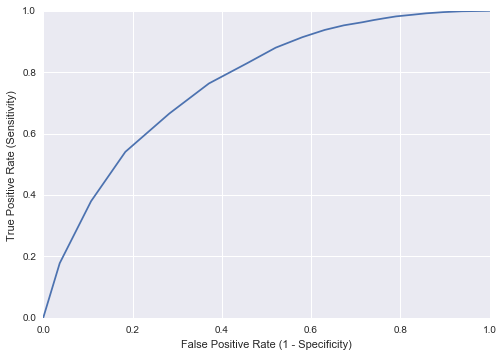

In [40]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_probs)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
# random is .5
# want area to be as close to 1

### Naive Bayes

In [ ]:
# No Paremeters. Model produces accuracy score of 68%. 

In [35]:
nb_model = GaussianNB()
nb_model.fit(X_train,y_train)
nb_model.score(X_test,y_test)

0.68755067443060369

### Decision Tree

The parameter "max depth" is searched yielding the best accuracy score of 80% with a max depth of 3.98. This means the tree can have leaves anywhere between 1 and 3.98 layers deep. 

In [39]:
tree_grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid={'max_depth': np.logspace(-3, 3, 6)})

In [40]:
tree_grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([  1.00000e-03,   1.58489e-02,   2.51189e-01,   3.98107e+00,
         6.30957e+01,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [41]:
tree_grid_search.best_params_

{'max_depth': 3.9810717055349691}

In [42]:
tree_grid_search.best_score_

0.80975548113982432

### Random Forest

The parameter n_estimators is searched yielding 1000 as the optimal parameter. n_estimators represents the number of trees in the forest. Note, code isn't run in this notebook.  

In [ ]:
forest_grid_search = GridSearchCV(RandomForestClassifier(), param_grid={'n_estimators': [10,100,1000]})
forest_grid_search.fit(X_train, y_train)
forest_grid_search.best_params_
forest_grid_search.best_score_

### SVC

For support vector classification, the parameter "C" represents the penalty of the error term. Searching through three values (.01,1,100) yields "1" as an optimal value of "C" with a 82% classification rate. 

In [43]:
svc_grid_search = GridSearchCV(SVC(), param_grid={'C': [.01,1,100]})

In [44]:
svc_grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={'C': [0.01, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [45]:
svc_grid_search.best_params_

{'C': 1}

In [46]:
svc_grid_search.best_score_

0.81888544891640869

## Voting Model Classifier <a name="Voting Model Classifier"></a>

In [47]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import VotingClassifier

Variables for each model are created using the optimal parameters found via grid search. Note, the decision tree model isn't used here due to running time constraints.

In [49]:
clf1 = LogisticRegression(C=1000,random_state=1)
clf2 = RandomForestClassifier(n_estimators=1000,random_state=1)
clf3 = GaussianNB()
clf4 = KNeighborsClassifier(n_neighbors=19)
clf5 = SVC(C=100)
# Soft: It adds all the probabilites, then averages the probabilites, takes the best

The VotingClassifier combines the various classification models and chooses a class based on different methods. The prediction score automatically does cross validation. 

The first voting method (voting="hard") means each model has a vote on predicting whether someone works less than or greater than/equal to 40 hours a week. It will take the majority of the votes, meaning if three out of five models predict "0" or less than 40 hours a week, then the classification will result in a "0"

In [50]:
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('knn', clf4),('SVC',clf5)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
print(eclf1.predict(X_test))
print(eclf1.score(X_test,y_test)) #automatically does cross validation

[1 1 1 ..., 1 0 1]
0.815950468047


The second voting method (voting="soft") means each model represents a probability of being a certain class. It then chooses the class based on an average of all the probabilities, and takes the more likely probability.

In [51]:
eclf2 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('knn', clf4)],voting='soft')
eclf2 = eclf2.fit(X_train, y_train)
print(eclf2.predict(X_test))
print(eclf2.score(X_test,y_test))

[1 1 1 ..., 1 0 1]
0.797670818899


The third voting method (voting="soft") with weights=[2,1,1,1] means that the class is being chosen based on a probabilistic approach but certain models are weighted more heavily in importance.

In [52]:
eclf3 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('knn', clf4)],voting='soft', weights=[2,1,1,1])
eclf3 = eclf3.fit(X_train, y_train)
print(eclf3.predict(X_test))
print(eclf3.score(X_test,y_test))

[1 1 1 ..., 1 0 1]
0.802830397288


 ## Conclusion <a name="Conclusion"></a>

This project created a script that called the census dataset by querying amazon web service to transform it into a workable dataframe. Then different classification models were tested on training and testing sections of the dataset using grid search to find optimal parameters. Finally, a voting classifer combined all the models and classified based on several voting methods. The first voting classifier "eclf1" produced a high accuracy score of 81.5% but the highest came from the sole use of the support vector classification model with an accuracy score of 81.8%.